In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"
test_url  = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2025-26/gws/merged_gw.csv"

train_df = pd.read_csv(train_url, on_bad_lines='skip', engine='python')
test_df  = pd.read_csv(test_url, on_bad_lines='skip', engine='python')

print("Datasets Loaded Successfully")
print(f"Training Data Shape: {train_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

Datasets Loaded Successfully
Training Data Shape: (29725, 41)
Testing Data Shape: (5821, 46)


In [5]:
train_df.columns = [c.lower().replace(" ", "_") for c in train_df.columns]
test_df.columns  = [c.lower().replace(" ", "_") for c in test_df.columns]

if 'name' not in train_df.columns and {'first_name', 'second_name'}.issubset(train_df.columns):
    train_df['name'] = train_df['first_name'] + " " + train_df['second_name']
if 'name' not in test_df.columns and {'first_name', 'second_name'}.issubset(test_df.columns):
    test_df['name'] = test_df['first_name'] + " " + test_df['second_name']

required_cols = ['name', 'team', 'round', 'total_points']
for col in required_cols:
    if col not in train_df.columns or col not in test_df.columns:
        raise ValueError(f"Missing required column: {col}")

train_df = train_df.sort_values(by=['name', 'round'])
test_df  = test_df.sort_values(by=['name', 'round'])

In [6]:
base_features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
    'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'value'
]

train_df = train_df.dropna(subset=base_features + ['total_points'])
test_df  = test_df.dropna(subset=base_features + ['total_points'])

print(f"Cleaned Train Data: {train_df.shape}")
print(f"Cleaned Test Data: {test_df.shape}")

Cleaned Train Data: (29725, 41)
Cleaned Test Data: (5821, 46)


In [7]:
rolling_data = []
for player in test_df['name'].unique():
    player_df = test_df[test_df['name'] == player].sort_values('round')
    if len(player_df) < 5:
        continue

    prev_window = player_df.tail(5)
    features_dict = {f'avg_{f}': prev_window[f].mean() for f in base_features}
    features_dict.update({
        'name': player,
        'team': prev_window['team'].values[-1],
        'current_round': int(prev_window['round'].values[-1]),
        'avg_points_last_5_gws': round(prev_window['total_points'].mean(), 2)
    })
    rolling_data.append(features_dict)

rolling_df = pd.DataFrame(rolling_data)
print(f"Built rolling dataset for 2025–26 players: {rolling_df.shape}")

Built rolling dataset for 2025–26 players: (740, 22)


In [8]:
X_train = train_df[base_features]
y_train = train_df['total_points']

X_test = rolling_df[[f'avg_{f}' for f in base_features if f'avg_{f}' in rolling_df.columns]].copy()
X_test.columns = [c.replace('avg_', '') for c in X_test.columns]
X_test = X_test[X_train.columns]

In [9]:
models = {
    "LightGBM": (lgb.LGBMRegressor(
        random_state=42,
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0
    ), {
        "n_estimators": [100, 200],
        "max_depth": [-1, 5, 10],
        "learning_rate": [0.05, 0.1],
        "num_leaves": [31, 63]
    }),
    "CatBoost": (cb.CatBoostRegressor(
        task_type='GPU',
        devices='0',
        random_state=42,
        verbose=0
    ), {
        "depth": [4, 6, 8],
        "learning_rate": [0.05, 0.1],
        "iterations": [200, 500],
        "l2_leaf_reg": [1, 3, 5]
    })
}

results = []
best_models = {}

print("\nRunning GPU-accelerated Grid Search for LightGBM and CatBoost...")

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV R²": grid.best_score_
    })
    print(f"{name} Best R²: {grid.best_score_:.4f} | Params: {grid.best_params_}")


Running GPU-accelerated Grid Search for LightGBM and CatBoost...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 29725, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1 dense feature groups (0.11 MB) transferred to GPU in 0.000456 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.052010
LightGBM Best R²: 0.9840 | Params: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}
CatBoost Best R²: 0.9848 | Params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [10]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

metrics = []
for name, model in best_models.items():
    model.fit(X_t, y_t)
    y_pred = model.predict(X_v)
    mae = mean_absolute_error(y_v, y_pred)
    r2 = r2_score(y_v, y_pred)
    metrics.append({"Model": name, "MAE": mae, "R²": r2})
    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 23780, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1 dense feature groups (0.09 MB) transferred to GPU in 0.005099 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.051892
LightGBM: MAE = 0.087, R² = 0.984
CatBoost: MAE = 0.093, R² = 0.983


,Model,MAE,R²
0,LightGBM,0.087306,0.983639
1,CatBoost,0.092579,0.983106


In [11]:
best_model_name = metrics_df.sort_values("R²", ascending=False).iloc[0]["Model"]
best_model = best_models[best_model_name]
print(f"\nBest Model Selected: {best_model_name}")

rolling_df['predicted_points_next_gw'] = best_model.predict(X_test)
pred_df = rolling_df.sort_values('predicted_points_next_gw', ascending=False)

print("\nTop 10 Predicted Performers for Next Gameweek:")
display(pred_df[['name', 'team', 'current_round', 'predicted_points_next_gw', 'avg_points_last_5_gws']].head(10))



Best Model Selected: LightGBM

Top 10 Predicted Performers for Next Gameweek:


,name,team,current_round,predicted_points_next_gw,avg_points_last_5_gws
235,Gabriel dos Santos Magalhães,Arsenal,9,11.945550,9.0
203,Erling Haaland,Man City,9,11.931911,10.6
619,Ryan Gravenberch,Liverpool,9,10.255526,5.6
636,Sean Longstaff,Leeds,9,10.095376,5.4
717,Yankuba Minteh,Brighton,9,9.487984,5.4
317,Jarrod Bowen,West Ham,9,9.406475,5.4
364,João Maria Lobo Alves Palhares Costa Palhinha ...,Spurs,9,9.389114,6.0
551,Nordi Mukiele,Sunderland,9,9.154302,7.8
562,Omar Alderete,Sunderland,9,8.875036,7.2
591,Reece James,Chelsea,9,8.733063,5.4


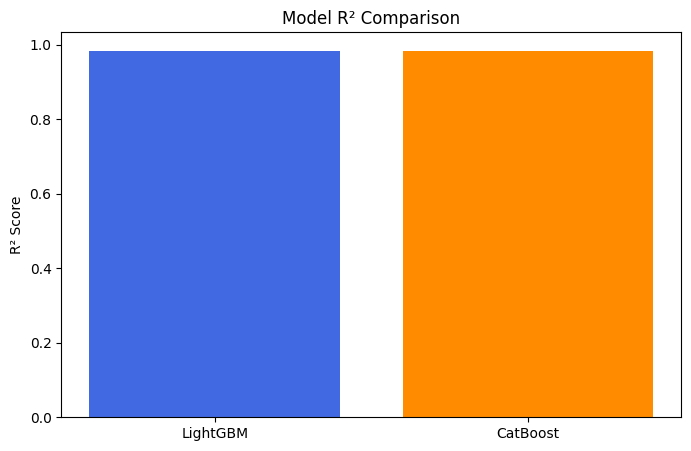

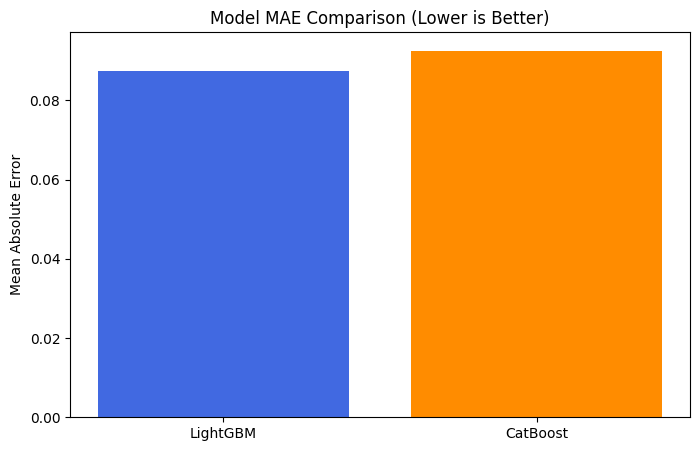

In [12]:
plt.figure(figsize=(8,5))
plt.bar(metrics_df["Model"], metrics_df["R²"], color=['royalblue', 'darkorange'])
plt.title("Model R² Comparison")
plt.ylabel("R² Score")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(metrics_df["Model"], metrics_df["MAE"], color=['royalblue', 'darkorange'])
plt.title("Model MAE Comparison (Lower is Better)")
plt.ylabel("Mean Absolute Error")
plt.show()

In [14]:
def predict_next_gw_for_player(player_name):
    player_pred = pred_df[pred_df['name'].str.contains(player_name, case=False, na=False)]
    if player_pred.empty:
        print(f"Player '{player_name}' not found.")
        return
    print(f"\nNext Gameweek Prediction ({best_model_name}) for '{player_name}':")
    display(player_pred[['name', 'team', 'current_round', 'predicted_points_next_gw', 'avg_points_last_5_gws']])

# Example usage
predict_next_gw_for_player("Erling Haaland")


Next Gameweek Prediction (LightGBM) for 'Erling Haaland':


,name,team,current_round,predicted_points_next_gw,avg_points_last_5_gws
203,Erling Haaland,Man City,9,11.931911,10.6
